# 04: Entangled feature steering

In [2]:
%pip install torch numpy matplotlib diffusers datasets tqdm transformers accelerate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np

from diffusers import PNDMScheduler, UNet2DConditionModel, StableDiffusionPipeline
from diffusers.models.transformers.transformer_2d import Transformer2DModel
from diffusers.models.attention_processor import Attention
from datasets import load_dataset
from functools import lru_cache, cached_property
from dataclasses import dataclass
from tqdm import tqdm
import math

from torch.cuda.amp import GradScaler, autocast

import pickle
import os
from contextlib import contextmanager
from PIL import Image

In [3]:
backend_name = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
backend_name

'mps'

In [4]:
dtype = torch.float32
if backend_name == "cuda:0":
    dtype = torch.float16
dtype

torch.float32

In [5]:
test = torch.zeros((1,4096, 320))

In [6]:
test.shape

torch.Size([1, 4096, 320])

In [7]:
test.mean(dim=(1,2)).shape

torch.Size([1])

In [8]:
model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=dtype)
pipe = pipe.to(backend_name)
pipe.safety_checker = None

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [10]:
original_forward = pipe.unet.forward

def intercepted_forward(sample, timestep, encoder_hidden_states, **kwargs):
    pipe.unet.current_timestep = timestep.item() if isinstance(timestep, torch.Tensor) else timestep

    return original_forward(sample, timestep, encoder_hidden_states, **kwargs)

pipe.unet.forward = intercepted_forward

  0%|          | 0/50 [00:00<?, ?it/s]

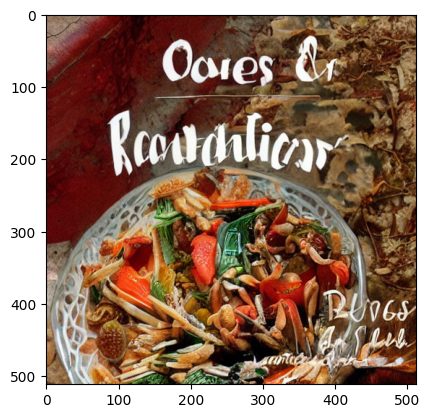

In [11]:
img = pipe(
    prompt="",
    num_inference_steps=50,
    guidance_scale=1.0
)
plt.imshow(img.images[0])

In [11]:
@contextmanager
def hook_context(module, hook_fn):
    handle = module.register_forward_hook(hook_fn)

    try:
        yield handle
    finally:
        handle.remove()

In [12]:
def create_steering_hook(alpha: float, t_range: tuple[int, int], channel_range: tuple[int, int]):
    def steer_activations_hook(module, input, output):
        # print(f"Steering activations of shape {output.shape}")
        print(module.__class__)
        print(input[0].shape)
        print(output[0].shape)
        t = pipe.unet.current_timestep

        if t_range[0] <= t <= t_range[1]:
            print(f"Steering at timestep {t}")
            if isinstance(module, Attention):
                print("Att")
                # (batch, latent_w*latent_h, channels [embedding dim])
                output[:, :, channel_range[0]:channel_range[1]] += alpha
                # output += alpha
            elif isinstance(module, Transformer2DModel):
                # (batch, channels [embedding dim], latent_w, latent_h)
                output[0][:, channel_range[0]:channel_range[1], :, :] += alpha
            else:
                # (batch, channels, latent_w, latent_h)
                output[:, channel_range[0]:channel_range[1], :, :] += alpha

        return output
    return steer_activations_hook

In [19]:
generator = torch.Generator(backend_name).manual_seed(22222) #12345
latents = torch.randn(
    (1, pipe.unet.config.in_channels, 64, 64),
    generator=generator,
    device=backend_name,
    dtype=pipe.unet.dtype
)

In [20]:

print(pipe.unet.up_blocks[1].attentions[1].__class__)

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>


In [21]:
@dataclass(frozen=True)
class E01Config:
    layer_name: str
    channel_range: tuple[int, int]
    alpha: float = 10.0
    prompt: str = ""
    t_range: tuple[int, int] = (0, 1000)


In [28]:
from functools import lru_cache

@lru_cache(maxsize=None)
def cached_pipe(prompt: str):
    return pipe(
        prompt="",
        latents=latents,
        num_inference_steps=50,
        # guidance_scale=1.0
    ).images[0]

def experiment_e01(config: E01Config):
    image_no_steering = cached_pipe(config.prompt)

    target_layer = dict(pipe.unet.named_modules())[config.layer_name]

    with hook_context(target_layer, create_steering_hook(config.alpha, config.t_range, config.channel_range)):
        image_steering = pipe(
            config.prompt,
            latents=latents,
            num_inference_steps=50,
            guidance_scale=1.0
        ).images[0]

    diff = np.abs(np.array(image_steering).astype(np.int16) - np.array(image_no_steering).astype(np.int16)).astype(np.uint8)
    diff_pil = Image.fromarray(diff)

    return image_no_steering, image_steering, diff_pil


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 981
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 941
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 921
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 901
<class 'diffusers.models.transformers.transfor

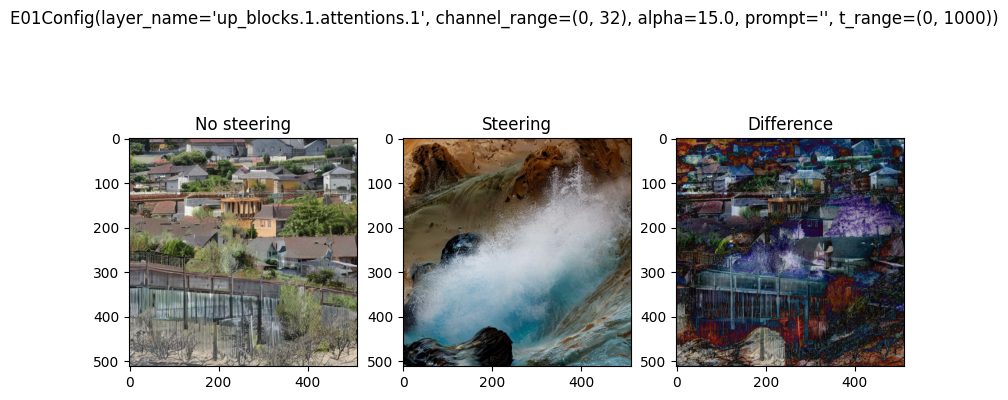

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 981
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 941
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 921
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 901
<class 'diffusers.models.transformers.transfor

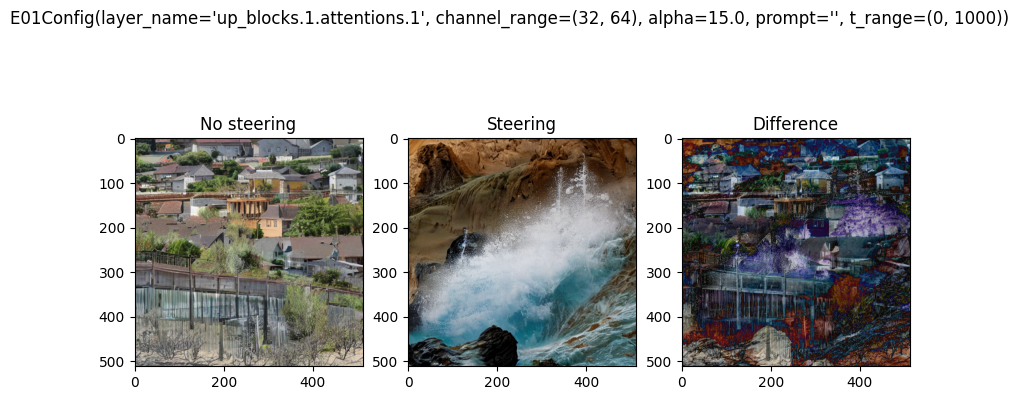

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 981
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 941
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 921
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 901
<class 'diffusers.models.transformers.transfor

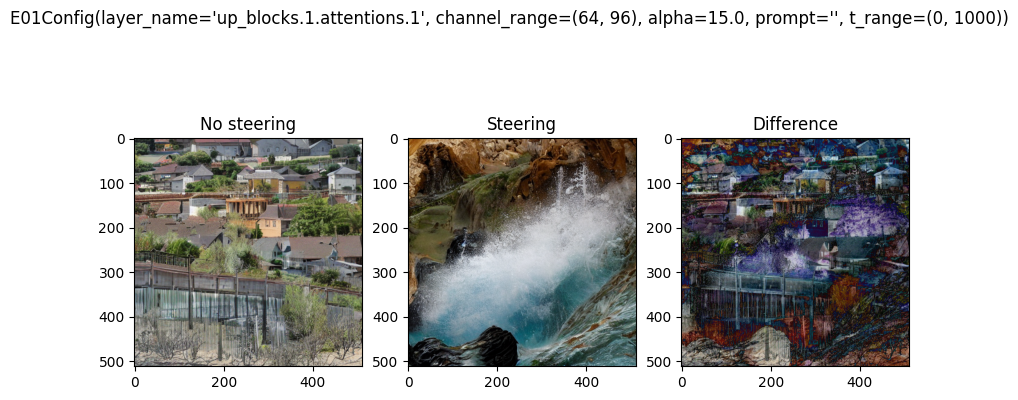

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 981
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 941
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 921
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 901
<class 'diffusers.models.transformers.transfor

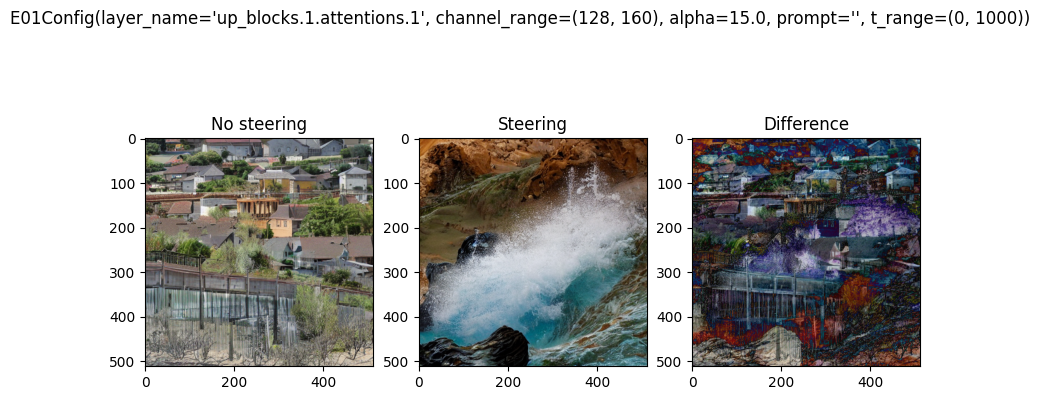

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 981
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 941
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 921
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 901
<class 'diffusers.models.transformers.transfor

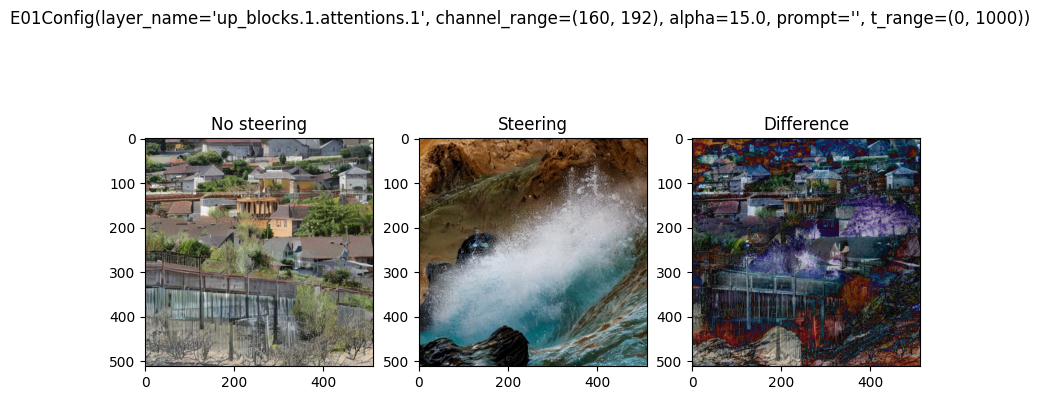

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 981
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 941
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 921
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 901
<class 'diffusers.models.transformers.transfor

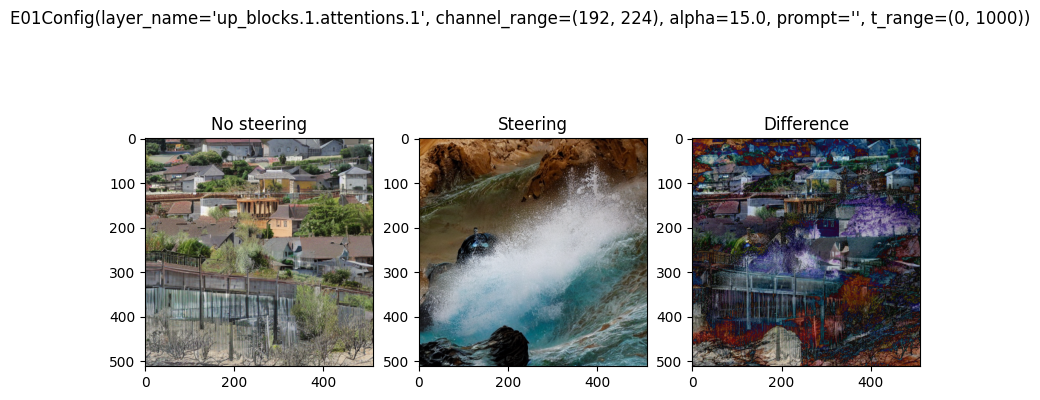

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 981
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 941
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 921
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 901
<class 'diffusers.models.transformers.transfor

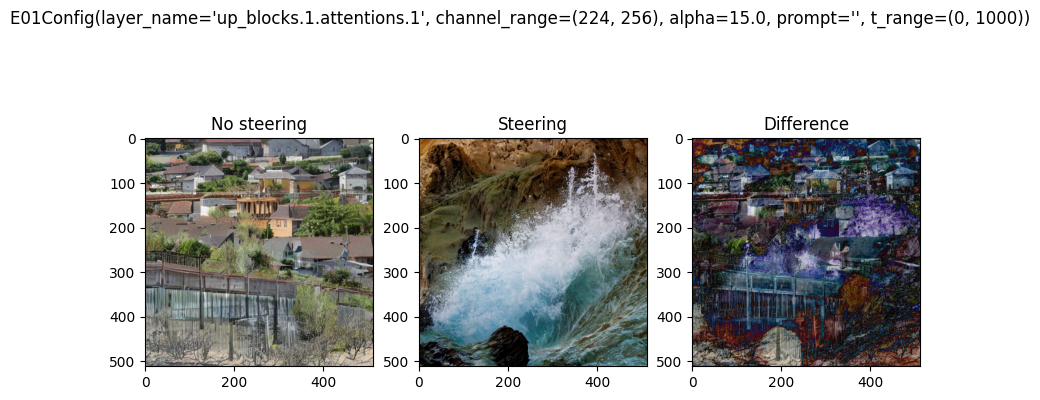

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 981
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 941
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 921
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 901
<class 'diffusers.models.transformers.transfor

In [ ]:
configs = [
    # Slice 1: Channels 0-64
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(0, 32), alpha=15.0),

    # Slice 2: Channels 64-128
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(32, 64), alpha=15.0),

    # Slice 3: Channels 128-192
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(64, 96), alpha=15.0),

    # Slice 4: Channels 192-256
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(128, 160), alpha=15.0),

    # Slice 5: Channels 256-320
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(160, 192), alpha=15.0),

    # Slice 6: Channels 320-384
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(192, 224), alpha=15.0),

    # Slice 7: Channels 384-448
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(224, 256), alpha=15.0),

    # Slice 8: Channels 448-512
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(448, 512), alpha=15.0),

    # Slice 9: Channels 512-576
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(512, 576), alpha=15.0),

    # Slice 10: Channels 576-640
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(576, 640), alpha=15.0),

    # Slice 11: Channels 640-704
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(640, 704), alpha=15.0),

    # Slice 12: Channels 704-768
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(704, 768), alpha=15.0),

    # Slice 13: Channels 768-832
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(768, 832), alpha=15.0),

    # Slice 14: Channels 832-896
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(832, 896), alpha=15.0),

    # Slice 15: Channels 896-960
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(896, 960), alpha=15.0),

    # Slice 16: Channels 960-1024
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(960, 1024), alpha=15.0),

    # Slice 17: Channels 1024-1088
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(1024, 1088), alpha=15.0),

    # Slice 18: Channels 1088-1152
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(1088, 1152), alpha=15.0),

    # Slice 19: Channels 1152-1216
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(1152, 1216), alpha=15.0),

    # Slice 20: Channels 1216-1280 (The final slice)
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(1216, 1280), alpha=15.0),
]

for config in configs:
    image_no_steering, image_steering, diff_pil = experiment_e01(config)

    plt.figure(figsize=(10, 5))
    plt.suptitle(config.__str__())
    plt.subplot(1, 3, 1)
    plt.imshow(image_no_steering)
    plt.title("No steering")
    plt.subplot(1, 3, 2)
    plt.imshow(image_steering)
    plt.title("Steering")
    plt.subplot(1, 3, 3)
    plt.imshow(diff_pil)
    plt.title("Difference")
    plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transform

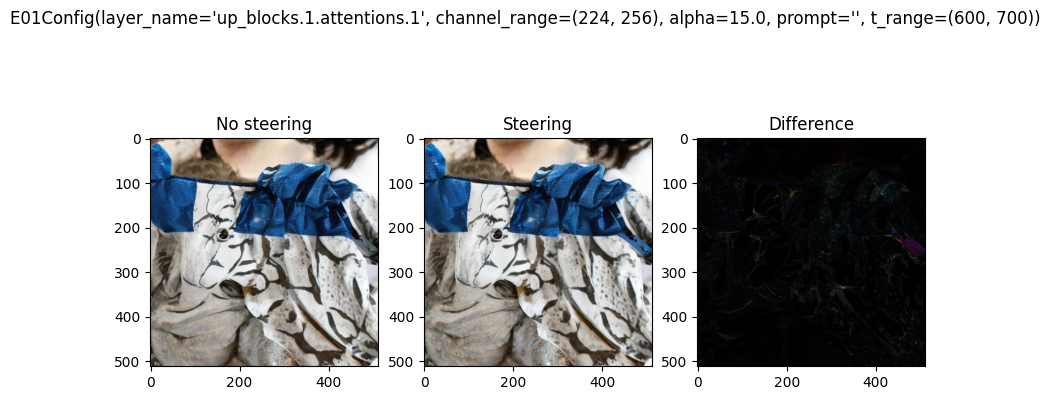

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transform

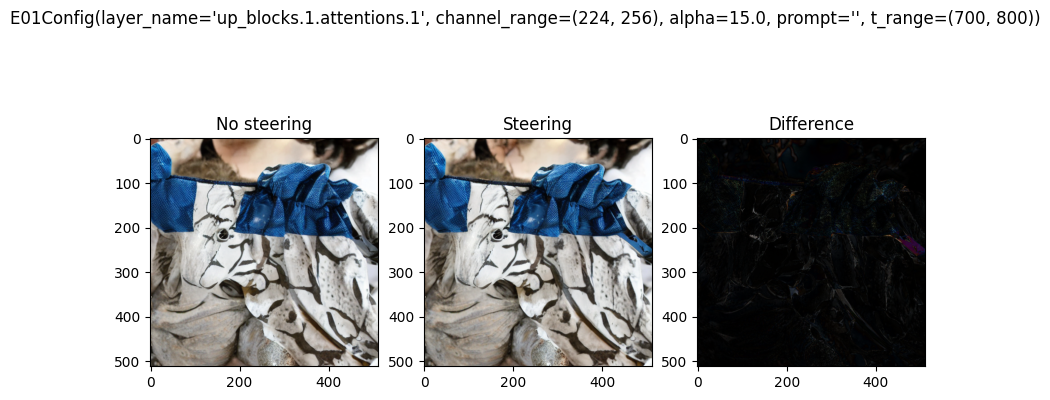

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 981
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 941
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 921
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 901
<class 'diffusers.models.transformers.transfor

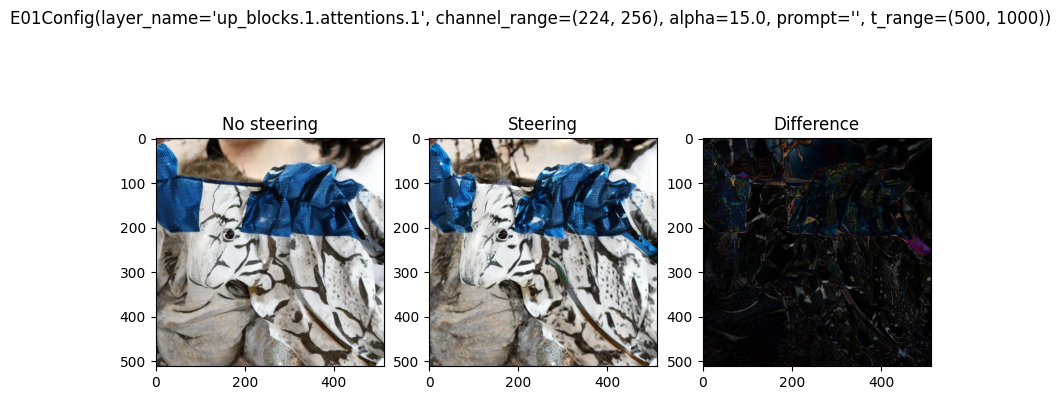

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transform

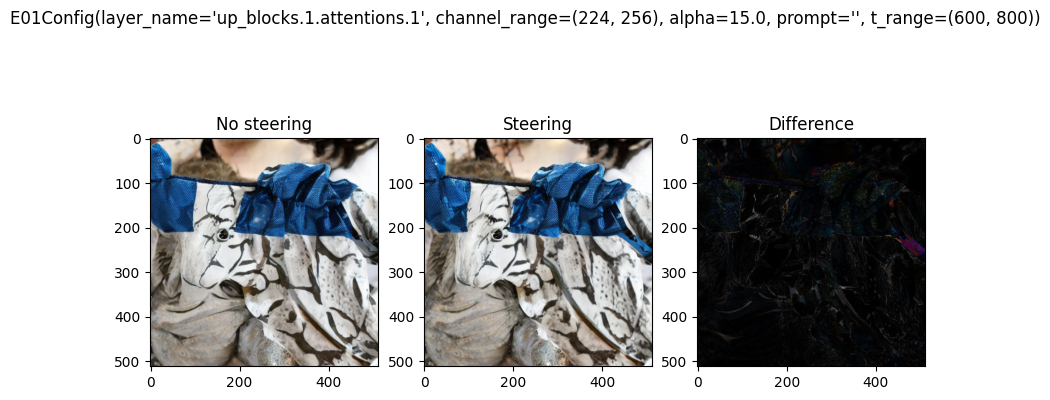

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transform

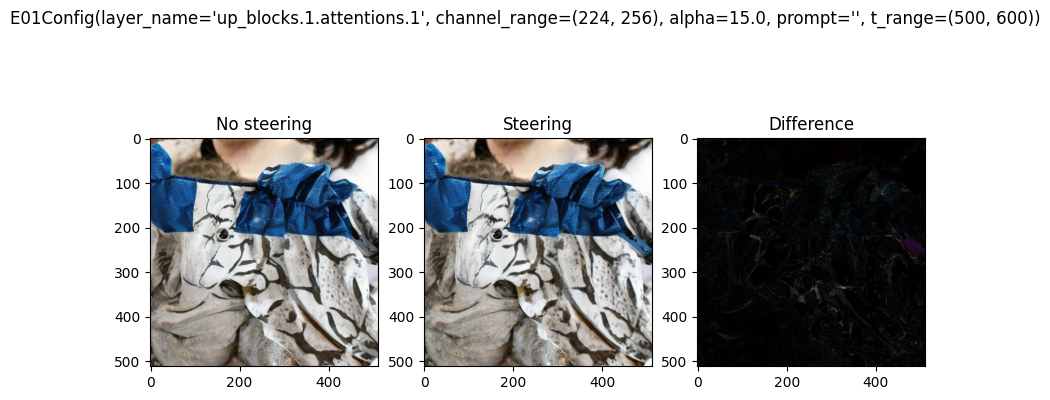

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 881
<class 'diffusers.models.transformers

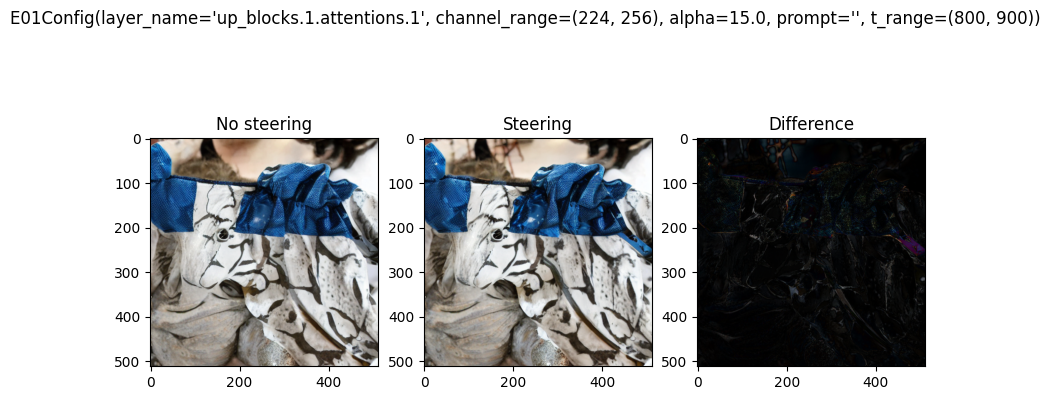

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 981
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 961
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 941
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 921
<class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>
torch.Size([1, 1280, 16, 16])
torch.Size([1, 1280, 16, 16])
Steering at timestep 901
<class 'diffusers.models.transformers.transfor

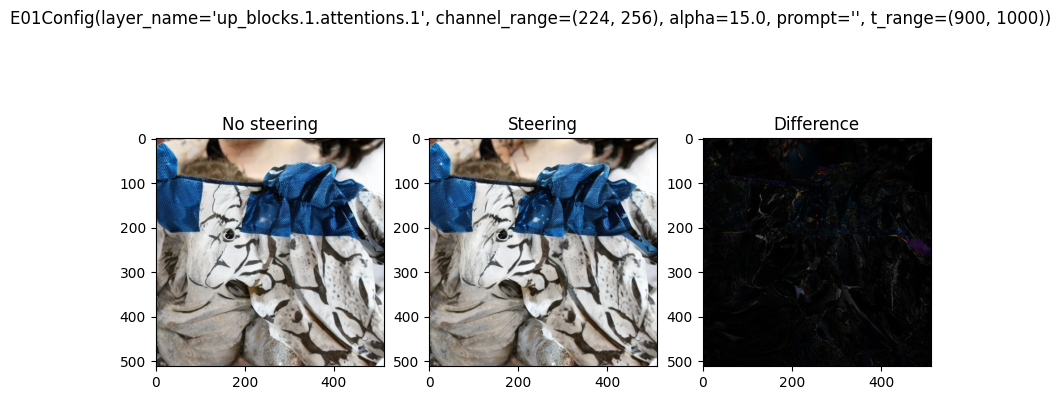

In [18]:
configs = [
    # Slice 7: Channels 384-448
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(224, 256), alpha=15.0, t_range=(600, 700)),
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(224, 256), alpha=15.0, t_range=(700, 800)),
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(224, 256), alpha=15.0, t_range=(500, 1000)),
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(224, 256), alpha=15.0, t_range=(600, 800)),
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(224, 256), alpha=15.0, t_range=(500, 600)),
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(224, 256), alpha=15.0, t_range=(800, 900)),
    E01Config(layer_name="up_blocks.1.attentions.1", channel_range=(224, 256), alpha=15.0, t_range=(900, 1000)),
]

for config in configs:
    image_no_steering, image_steering, diff_pil = experiment_e01(config)

    plt.figure(figsize=(10, 5))
    plt.suptitle(config.__str__())
    plt.subplot(1, 3, 1)
    plt.imshow(image_no_steering)
    plt.title("No steering")
    plt.subplot(1, 3, 2)
    plt.imshow(image_steering)
    plt.title("Steering")
    plt.subplot(1, 3, 3)
    plt.imshow(diff_pil)
    plt.title("Difference")
    plt.show()
